### Laboratorium 4 - zadania

Dany jest zbiór obrazów wraz z etykietami - maskami segmentacji. Twoim zadaniem jest zaproponować metodę binaryzacji obrazów, zaimplementować odpowiednie metryki oceny i wykorzystać je do określenia jakości detekcji w zależności od parametrów metody.

Pytania zadane kursywą możesz traktować jako "zajawki" do sprawozdania.

Dołączony w zadaniu dataset jest podzbiorem datasetu dostępnego w oryginale na portalu [Kaggle](https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy).

In [1]:
import os
from typing import Iterator, List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

Do podanego zbioru danych zaimplementowany został poniższy loader. Możesz korzystać z niego albo przez interfejs listy (`loader[3]`) albo przez interfejs iteracyjny (`for sample in loader`). W obu przypadkach zwracana jest para (obraz, etykieta), gdzie obraz jest 3-kanałowym obrazem **RGB** a etykieta 1-kanałowym obrazem o wartościach 0 (tło) i 1 (obiekt-bakteria). Poniższa komórka zawiera przykład.

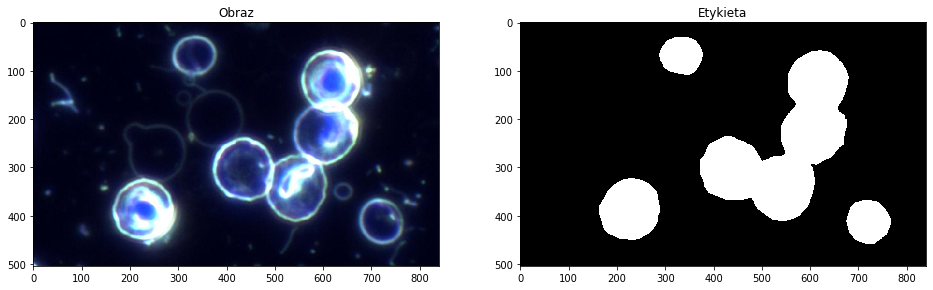

In [2]:
class BacteriaLoader:
    SUBSET = 89, 155
    def __init__(self, root:str, train:bool=True) -> None:
        """
        root (str): path to the folder containing 'images', 'masks' and 'meta.json'
        train (bool): if True, returns the calibration subset, otherwise the validation subset
        """
        image_names = os.listdir(os.path.join(root, 'images'))
        mask_names = os.listdir(os.path.join(root, 'masks'))
        valid_names = self.get_names()
        if any(name not in image_names or name not in mask_names for name in valid_names):
            raise FileNotFoundError("Dataset malformed: files missing.")
        image_names = [os.path.join(root, 'images', file_name) for file_name in valid_names]
        mask_names = [os.path.join(root, 'masks', file_name) for file_name in valid_names]
        test_image_names = image_names[::3]
        train_image_names = [name for name in image_names if name not in test_image_names]
        self.image_names = train_image_names if train else test_image_names
        test_mask_names = mask_names[::3]
        train_mask_names = [name for name in mask_names if name not in test_mask_names]
        self.mask_names = train_mask_names if train else test_mask_names

    def get_names(self) -> List[str]:
        return ['{:03d}.png'.format(i) for i in range(*self.SUBSET)]

    def __getitem__(self, index:int) -> Tuple[np.ndarray, np.ndarray]:
        image = cv2.imread(self.image_names[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_ = cv2.imread(self.mask_names[index], cv2.IMREAD_GRAYSCALE)
        mask = np.zeros_like(mask_, dtype=np.uint8)
        mask[mask_==1] = 1  # pozostałe obiekty ignorujemy
        return image, mask

    def __len__(self) -> int:
        return len(self.image_names)

    def __iter__(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        for i in range(len(self)):
            yield self[i]


loader = BacteriaLoader('BacteriaKaggle')
image, mask = loader[21]
f, (axi, axm) = plt.subplots(1, 2)
f.set_figwidth(16)
f.set_figheight(8)
axi.imshow(image, interpolation='none');
axi.set_title('Obraz');
axm.imshow(mask*100, interpolation='none', cmap='gray');
axm.set_title('Etykieta');

#### Zadanie 1 (1.0 pkt | 0.5 pkt)

Zaimplementuj w funkcji `detect_bacteria` taki algorytm przetwarzania obrazu, by uzyskać wizualnie akceptowalną binaryzację. Użyj operacji morfologicznych do odfiltrowania artefaktów. Nie staraj się na tym etapie dążyć do idealnych rezultatów - dokładny dobór parametrów algorytmu będzie jednym z następnych kroków.

Do testowania użyj poniższej komórki. Zwróć uwagę na interfejs `**params` - przekazywanie parametrów metody (np. wartości progów, rozmiary kerneli) tą drogą znacznie uprości pracę na dalszych etapach. W razie potrzeby, zapoznaj się z pythonowym mechanizmem [`kwargs`](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

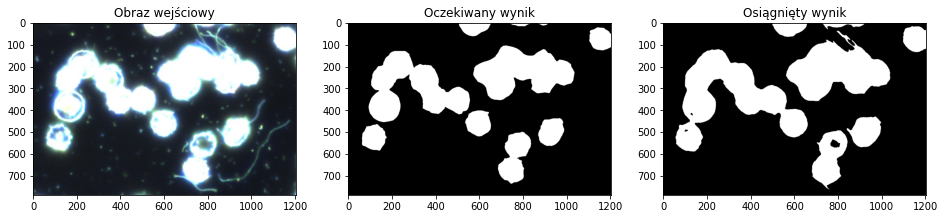

In [63]:
def detect_bacteria(image:np.ndarray, **params) -> np.ndarray:
    # wartości parametrów przekazuj w 'params', np.: params['threshold']
    kernel = np.eye(params['kernel'], dtype=np.uint8)
    if params['channel'] == 'mean':
        output = image.mean(axis=2).astype(np.uint8)
    else:
        output = image[...,params['channel']]
    # output = np.zeros_like(image[..., 0], dtype=np.uint8)
    for _ in range(params.setdefault('openings', 1)):
        output = cv2.erode(output, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
        output = cv2.dilate(output, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    if params['threshold'] == 'otsu':
        _, output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, output = cv2.threshold(output, params['threshold'], 255, cv2.THRESH_BINARY)
    return output

dev_image, dev_mask = loader[0] # sprawdź też inne przykłady, np. 9, 37
output = detect_bacteria(dev_image, threshold='otsu', kernel=15, channel='mean', openings=1)

# wyświetlanie
f, (a_img, a_mask, a_pred) = plt.subplots(1, 3)
f.set_figwidth(16)
f.set_figheight(8)
a_img.imshow(dev_image)
a_img.set_title('Obraz wejściowy');
a_mask.imshow(dev_mask, cmap='gray')
a_mask.set_title('Oczekiwany wynik');
a_pred.imshow(output, cmap='gray')
a_pred.set_title('Osiągnięty wynik');

#### Zadanie 2 (1.0 pkt | 0.5 pkt)

Zaimplementuj funkcję `measure` w taki sposób, by wyliczała wybrane przez Ciebie metryki (uwzględnij co najmniej precyzję, czułość, oraz indeks Jaccarda) i zwracała je w formie słownika. Wykorzystaj ją do określenia błędu pomiędzy wynikiem działania twojej funkcji, a maską dla różnych wartości wybranych parametrów (patrz: przykład). Wykonaj testy dla kilku odróżniających się przykładów.  
_Co stanowi przyczynę błędów? Zwróć uwagę na specyfikę obrazów i zasady działania stosowanych algorytmów._

C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


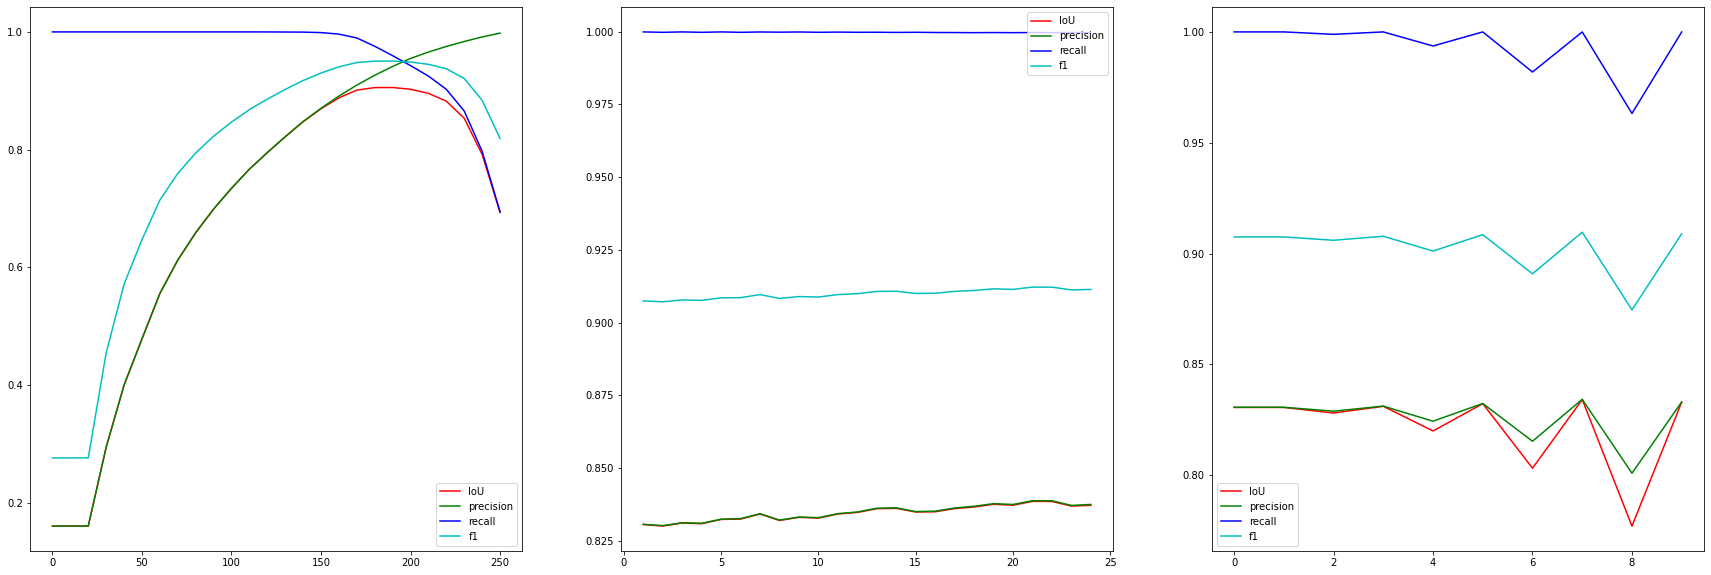

In [66]:
from sklearn import metrics
from copy import copy

def measure(predicted, truth):
    predicted = predicted.flatten().astype(bool)
    truth = truth.flatten().astype(bool)
    scores = {}
    scores['precision'] = metrics.precision_score(truth, predicted)
    scores['recall'] = metrics.recall_score(truth, predicted)
    scores['f1'] = metrics.f1_score(truth, predicted)
    scores['iou'] = metrics.jaccard_score(truth, predicted)
    return scores

def plot_results(default_params, params, samples):
    fig, ax = plt.subplots(1,len(params), figsize=(10*len(params),10))
    for i in range(len(params)):
        param_values = []
        iou_values = []
        precision_values = []
        recall_values = []
        f1_values = []
        for test_image, test_mask in samples:
            param_values.append([])
            iou_values.append([])
            precision_values.append([])
            recall_values.append([])
            f1_values.append([])
            for param_val in params[params.keys()[i]]:
                cur_params = copy(default_params)
                cur_params[params.keys()[i]] = param_val
                output = detect_bacteria(test_image, **cur_params)
                m = measure(output, test_mask)
                param_values[-1].append(param_val)
                iou_values[-1].append(m['iou'])
                precision_values[-1].append(m['precision'])
                recall_values[-1].append(m['recall'])
                f1_values[-1].append(m['f1'])
        ax[i].plot(param_values, iou_values, c='r', label='IoU')
        ax[i].plot(param_values, precision_values, c='g', label='precision')
        ax[i].plot(param_values, recall_values, c='b', label='recall')
        ax[i].plot(param_values, f1_values, c='c', label='f1')
        ax[i].legend();


test_image, test_mask = loader[1]

fig, ax = plt.subplots(1,3, figsize=(30,10))

param_values = []
iou_values = []
precision_values = []
recall_values = []
f1_values = []
for param_val in range(0, 260, 10):
    output = detect_bacteria(test_image, threshold=param_val, kernel=15, channel='mean')
    m = measure(output, test_mask)
    param_values.append(param_val)
    iou_values.append(m['iou'])
    precision_values.append(m['precision'])
    recall_values.append(m['recall'])
    f1_values.append(m['f1'])
ax[0].plot(param_values, iou_values, c='r', label='IoU')
ax[0].plot(param_values, precision_values, c='g', label='precision')
ax[0].plot(param_values, recall_values, c='b', label='recall')
ax[0].plot(param_values, f1_values, c='c', label='f1')
ax[0].legend();

param_values = []
iou_values = []
precision_values = []
recall_values = []
f1_values = []
for param_val in range(1, 25, 1):
    output = detect_bacteria(test_image, threshold='otsu', kernel=param_val, channel='mean')
    m = measure(output, test_mask)
    param_values.append(param_val)
    iou_values.append(m['iou'])
    precision_values.append(m['precision'])
    recall_values.append(m['recall'])
    f1_values.append(m['f1'])
ax[1].plot(param_values, iou_values, c='r', label='IoU')
ax[1].plot(param_values, precision_values, c='g', label='precision')
ax[1].plot(param_values, recall_values, c='b', label='recall')
ax[1].plot(param_values, f1_values, c='c', label='f1')
ax[1].legend();

param_values = []
iou_values = []
precision_values = []
recall_values = []
f1_values = []
for param_val in range(0, 10, 1):
    output = detect_bacteria(test_image, threshold='otsu', kernel=param_val, channel='mean', openings=param_val)
    m = measure(output, test_mask)
    param_values.append(param_val)
    iou_values.append(m['iou'])
    precision_values.append(m['precision'])
    recall_values.append(m['recall'])
    f1_values.append(m['f1'])
ax[2].plot(param_values, iou_values, c='r', label='IoU')
ax[2].plot(param_values, precision_values, c='g', label='precision')
ax[2].plot(param_values, recall_values, c='b', label='recall')
ax[2].plot(param_values, f1_values, c='c', label='f1')
ax[2].legend();

fig.set_constrained_layout(True)

#### Zadanie 3 (1.0 pkt | 0.5 pkt)

Przeanalizuj wpływ wybranych parametrów na średnią jakość predykcji na całym zbiorze testowym. Wybierz na tej podstawie najlepszą kombinację parametrów.  
_Zwracaj uwagę na odchylenie standardowe dla średniej. Czy w zbiorze występują próbki, z którymi Twój algorytm szczególnie sobie nie radzi?_

Jeśli starczy czasu: wykonaj drugą iterację kalibracji w oparciu o wyniki, starając się poprawić binaryzację dla "trudnych" przykładów.

#### Zadanie 4 (0.0 pkt | 0.5 pkt)

Przetestuj działanie tak skalibrowanego algorytmu na zbiorze walidacyjnym.  
_Jak wyniki mają się do tych ze zbioru kalibracyjnego? Dlaczego?_

In [5]:
val_loader = BacteriaLoader(root='BacteriaKaggle', train=False)